In [42]:
import re
import json
import fileinput
import pandas as pd
import gensim
import numpy as np
import nltk
import os
import random
import sklearn.metrics
import sklearn.model_selection
from sklearn.manifold import TSNE
import sklearn.datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, TweetTokenizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale

In [2]:
# Download the 'stopwords' and 'punkt' from the Natural Language Toolkit, you can comment the next lines if already present.
nltk.download('stopwords')
nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('tagsets')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('train_labeled_data.csv', encoding='ISO-8859-1', header = None)

In [4]:
df.columns = ["sentiment_label", "tweet_id", "date", "flag", "user", "tweet"]

In [5]:
df.drop(['tweet_id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [6]:
df1 = df[df.sentiment_label.isnull() == False]

In [7]:
df1 = df[df.tweet.isnull() == False]

In [8]:
df1.reset_index(inplace=True)

In [9]:
df1.drop('index', axis=1, inplace=True)

In [10]:
df1['sentiment_label'] = df1['sentiment_label'].map( {4:1, 0:0} )

In [11]:
# Extract features from a given text
def extract_tokens(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = list(filter(lambda t: not t.startswith('@'), tokens))
    tokens = list(filter(lambda t: not t.startswith('#'), tokens))
    tokens = list(filter(lambda t: not t.startswith('http'), tokens))
    
    return tokens

In [12]:
def data_process(data, n = 1000000):
    data = data.head(n)
    data['tokens'] = data['tweet'].map(extract_tokens)
    
    return data

In [13]:
df1 = data_process(df1)

C:\Users\HP\Anaconda2\envs\py3k\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
df1 = df1[df1.tokens != 'NC']
df1.reset_index(inplace=True)
df1.drop('index', inplace=True, axis=1)

In [15]:
n = 1000000

In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df1.head(n).tokens), np.array(df1.head(n).sentiment_label), test_size=0.2)

In [17]:
lsentence = gensim.models.doc2vec.LabeledSentence

In [18]:
def label_tweets(text, ltype):
    labelized = []
    for i,v in tqdm(enumerate(text)):
        label = '%s_%s'%(ltype,i)
        labelized.append(lsentence(v, [label]))
    return labelized

In [19]:
x_train = label_tweets(x_train, 'TRAIN')
x_test = label_tweets(x_test, 'TEST')

800000it [00:05, 140055.91it/s]
200000it [00:01, 125781.08it/s]


In [20]:
x_train[0]

LabeledSentence(words=['I', 'hate', 'that', 'feeling', 'when', "I'm", 'smoking', 'a', 'square', 'and', 'then', 'I', 'really', 'have', 'to', 'use', 'the', 'bathroom', '!'], tags=['TRAIN_0'])

In [21]:
n_dim = 200

In [22]:
w2v_model = Word2Vec(size=n_dim, min_count=10)
w2v_model.build_vocab([x.words for x in tqdm(x_train)])
w2v_model.train([x.words for x in tqdm(x_train)], total_examples = w2v_model.corpus_count, epochs = w2v_model.iter )

100%|█████████████████████████████████████████████████████████████████████| 800000/800000 [00:00<00:00, 1278436.00it/s]


43724728

In [23]:
w2v_model.most_similar('good')

[('great', 0.7321775555610657),
 ('goood', 0.6730692386627197),
 ('nice', 0.6430094242095947),
 ('fantastic', 0.6329206228256226),
 ('terrible', 0.6317780017852783),
 ('tough', 0.624709963798523),
 ('pleasant', 0.622956395149231),
 ('rough', 0.6169503927230835),
 ('brilliant', 0.6152041554450989),
 ('rubbish', 0.6139236092567444)]

In [29]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:500])

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

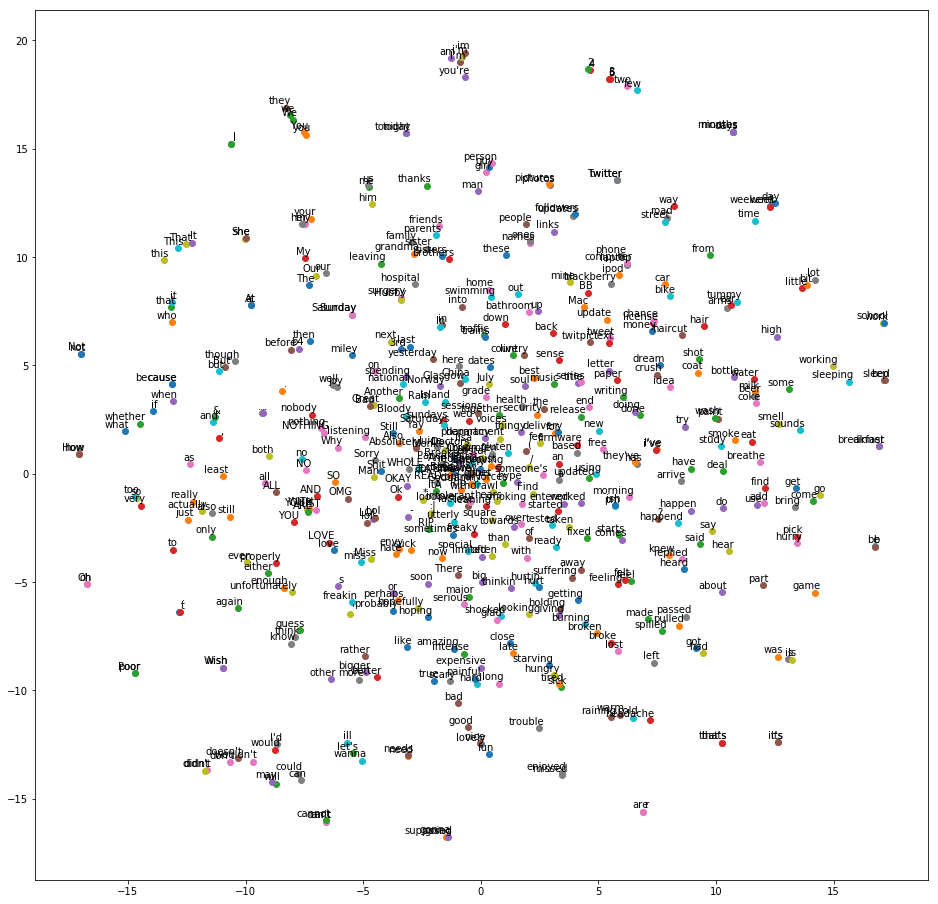

In [30]:
tsne_plot(w2v_model)

In [31]:
build_matrix = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
tfidf_matrix = build_matrix.fit_transform([x.words for x in x_train])
tfidf = dict(zip(build_matrix.get_feature_names(), build_matrix.idf_))

In [35]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [36]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)


0it [00:00, ?it/s]
499it [00:00, 4976.85it/s]
1249it [00:00, 5410.88it/s]
2011it [00:00, 5721.94it/s]
2653it [00:00, 5900.79it/s]
3343it [00:00, 6160.28it/s]
3965it [00:00, 6165.34it/s]
4553it [00:00, 6068.67it/s]
5399it [00:00, 6403.85it/s]
6093it [00:00, 6540.49it/s]
6792it [00:01, 6659.67it/s]
7606it [00:01, 6777.70it/s]
8296it [00:01, 6802.64it/s]
8973it [00:01, 6419.54it/s]
9617it [00:01, 6363.28it/s]
10377it [00:01, 6505.80it/s]
11109it [00:01, 6722.71it/s]
11891it [00:01, 6900.97it/s]
12586it [00:01, 6911.09it/s]
13367it [00:02, 6979.54it/s]
14067it [00:02, 6950.66it/s]
14764it [00:02, 6672.35it/s]
15435it [00:02, 6323.16it/s]
16074it [00:02, 6077.89it/s]
16689it [00:02, 6076.69it/s]
17302it [00:02, 5814.42it/s]
17889it [00:02, 5811.57it/s]
18597it [00:02, 6132.23it/s]
19371it [00:02, 6311.91it/s]
20058it [00:03, 6449.48it/s]
20709it [00:03, 6460.04it/s]
21396it [00:03, 6304.58it/s]
22030it [00:03, 6013.81it/s]
22637it [00:03, 5368.50it/s]
23191it [00:03, 5414.57it/s]
23745it [

In [43]:
model = keras.Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=2)

Epoch 1/9
 - 31s - loss: 0.3550 - acc: 0.8513
Epoch 2/9
 - 33s - loss: 0.3423 - acc: 0.8564
Epoch 3/9
 - 33s - loss: 0.3388 - acc: 0.8576
Epoch 4/9
 - 34s - loss: 0.3367 - acc: 0.8591
Epoch 5/9
 - 31s - loss: 0.3353 - acc: 0.8593
Epoch 6/9
 - 27s - loss: 0.3344 - acc: 0.8597
Epoch 7/9
 - 27s - loss: 0.3336 - acc: 0.8603
Epoch 8/9
 - 27s - loss: 0.3329 - acc: 0.8605
Epoch 9/9
 - 31s - loss: 0.3326 - acc: 0.8609


In [45]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])

0.858245
